# Migrate quantization from POT API to NNCF

This tutorial demonstrates how to migrate quantization pipeline written using the OpenVINO [Post-Training Optimization Tool (POT)](https://docs.openvino.ai/latest/pot_introduction.html) to [NNCF Post-Training Quantization API](https://docs.openvino.ai/latest/nncf_ptq_introduction.html). This tutorial is based on  [Ultralytics Yolov5](https://github.com/ultralytics/yolov5) model and additionally it compares model accuracy between the FP32 precision and quantized INT8 precision models and runs a demo of model inference based on sample code from [Ultralytics Yolov5](https://github.com/ultralytics/yolov5) with the OpenVINO backend.

The tutorial consist from following parts:

1. Convert YOLOv5 model to OpenVINO IR.
2. Prepare dataset for quantization.
3. Configure quantization pipeline.
4. Perform model optimization.
5. Compare accuracy FP32 and INT8 models
6. Run model inference demo
7. Compare performance FP32 and INt8 models

## Preparation

### Download the YOLOv5 model

In [1]:
!pip install -q psutil "seaborn>=0.11.0"


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Markdown, display

if not Path("./yolov5/").exists():
    command_download = (
        f'{"git clone https://github.com/ultralytics/yolov5.git -b v7.0"}'
    )
    command_download = " ".join(command_download.split())
    print("Download Ultralytics Yolov5 project source:")
    display(Markdown(f"`{command_download}`"))
    download_res = %sx $command_download
else:
    print("Ultralytics Yolov5 repo already exists.")

Download Ultralytics Yolov5 project source:


`git clone https://github.com/ultralytics/yolov5.git -b v7.0`

### Conversion of the YOLOv5 model to OpenVINO
There are three variables provided for easy run through all the notebook cells.
* `IMAGE_SIZE` - the image size for model input.
* `MODEL_NAME` - the model you want to use. It can be either yolov5s, yolov5m or yolov5l and so on.
* `MODEL_PATH` - to the path of the model directory in the YOLOv5 repository.

YoloV5 `export.py` scripts support multiple model formats for conversion. ONNX is also represented among supported formats. We need to specify `--include ONNX` parameter for exporting. As the result, directory with the `{MODEL_NAME}` name will be created with the following content:
* `{MODEL_NAME}.pt` - the downloaded pre-trained weight.
* `{MODEL_NAME}.onnx` - the Open Neural Network Exchange (ONNX) is an open format, built to represent machine learning models.

In [3]:
IMAGE_SIZE = 640
MODEL_NAME = "yolov5m"
MODEL_PATH = f"yolov5/{MODEL_NAME}"

In [4]:
print("Convert PyTorch model to OpenVINO Model:")
command_export = f"cd yolov5 && python export.py --weights {MODEL_NAME}/{MODEL_NAME}.pt --imgsz {IMAGE_SIZE} --batch-size 1 --include ONNX"
display(Markdown(f"`{command_export}`"))
! $command_export

Convert PyTorch model to OpenVINO Model:


`cd yolov5 && python export.py --weights yolov5m/yolov5m.pt --imgsz 640 --batch-size 1 --include ONNX`

export: data=data/coco128.yaml, weights=['yolov5m/yolov5m.pt'], imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['ONNX']
YOLOv5 🚀 v7.0-0-g915bbf2 Python-3.8.10 torch-1.13.1+cpu CPU

100%|██████████████████████████████████████| 40.8M/40.8M [00:07<00:00, 5.55MB/s]

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients

PyTorch: starting from yolov5m/yolov5m.pt with output shape (1, 25200, 85) (40.8 MB)

ONNX: starting export with onnx 1.13.1...
ONNX: export success ✅ 1.0s, saved as yolov5m/yolov5m.onnx (81.2 MB)

Export complete (12.3s)
Results saved to /home/ea/work/openvino_notebooks/notebooks/111-yolov5-quantization-migration/yolov5/yolov5m
Detect:          python detect.py --weights yolov5m/yolov5m.onnx 
Validate:        python 

Convert the ONNX model to OpenVINO Intermediate Representation (IR) model generated by [Model Optimizer](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html#doxid-openvino-docs-m-o-d-g-deep-learning-model-optimizer-dev-guide). We will use [Model Optimizer Python API](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Python_API.html) `openvino.tools.mo.convert_model` function to convert ONNX model to OpenVINO Model, then it can be seralized using `openvino.runtime.serialize`As the result, directory with the `{MODEL_DIR}` name will be created with the following content:
* `{MODEL_NAME}_fp32.xml`, `{MODEL_NAME}_fp32.bin` - OpenVINO Intermediate Representation (IR) model format with FP32 precision generated by Model Optimizer.
* `{MODEL_NAME}_fp16.xml`, `{MODEL_NAME}_fp16.bin` - OpenVINO Intermediate Representation (IR) model format with FP32 precision generated by Model Optimizer.

In [5]:
from openvino.tools import mo
from openvino.runtime import serialize

onnx_path = f"{MODEL_PATH}/{MODEL_NAME}.onnx"

# fp32 IR model
fp32_path = f"{MODEL_PATH}/FP32_openvino_model/{MODEL_NAME}_fp32.xml"

print(f"Export ONNX to OpenVINO FP32 IR to: {fp32_path}")
model = mo.convert_model(onnx_path)
serialize(model, fp32_path)

# fp16 IR model
fp16_path = f"{MODEL_PATH}/FP16_openvino_model/{MODEL_NAME}_fp16.xml"

print(f"Export ONNX to OpenVINO FP16 IR to: {fp16_path}")
model = mo.convert_model(onnx_path, compress_to_fp16=True)
serialize(model, fp16_path)

Export ONNX to OpenVINO FP32 IR to: yolov5/yolov5m/FP32_openvino_model/yolov5m_fp32.xml
Export ONNX to OpenVINO FP16 IR to: yolov5/yolov5m/FP16_openvino_model/yolov5m_fp16.xml


### Imports

In [6]:
sys.path.append("./yolov5")

from yolov5.utils.dataloaders import create_dataloader
from yolov5.utils.general import check_dataset

## Prepare dataset for quantization

Before starting quantization, we should prepare dataset, which will be used for quantization. Ultralytics YOLOv5 provides data loader for iteration overdataset during training and validation. Let's create it first.

In [7]:
from yolov5.utils.general import download

DATASET_CONFIG = "./yolov5/data/coco128.yaml"


def create_data_source():
    """
    Creates COCO 2017 validation data loader. The method downloads COCO 2017
    dataset if it does not exist.
    """
    if not Path("datasets/coco128").exists():
        urls = ["https://ultralytics.com/assets/coco128.zip"]
        download(urls, dir="datasets")

    data = check_dataset(DATASET_CONFIG)
    val_dataloader = create_dataloader(
        data["val"], imgsz=640, batch_size=1, stride=32, pad=0.5, workers=1
    )[0]

    return val_dataloader


data_source = create_data_source()

  0%|          | 0.00/6.66M [00:00<?, ?B/s]

Unzipping datasets/coco128.zip...
Scanning /home/ea/work/openvino_notebooks/notebooks/111-yolov5-quantization-migration/datasets/coco128/labels/train2017... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 00:00
New cache created: /home/ea/work/openvino_notebooks/notebooks/111-yolov5-quantization-migration/datasets/coco128/labels/train2017.cache


### Create YOLOv5 DataLoader class for POT

Create a class for loading the YOLOv5 dataset and annotation which inherits from POT API class DataLoader. 
`openvino.tools.pot.DataLoader` interface allows acquiring data from a dataset and applying model-specific pre-processing providing access by index. Any implementation should override the following methods:

* The `__len__()`, returns the size of the dataset.

* The `__getitem__()`, provides access to the data by index in range of 0 to len(self). It can also encapsulate the logic of model-specific pre-processing. This method should return data in the (data, annotation) format, in which:

    * The `data` is the input that is passed to the model at inference so that it should be properly preprocessed. It can be either the numpy.array object or a dictionary, where the key is the name of the model input and value is numpy.array which corresponds to this input.

    * The `annotation` is not used by the Default Quantization method. Therefore, this object can be None in this case.


In [8]:
from openvino.tools.pot.api import DataLoader

class YOLOv5POTDataLoader(DataLoader):
    """Inherit from DataLoader function and implement for YOLOv5."""

    def __init__(self, data_source):
        super().__init__({})
        self._data_loader = data_source

    def __len__(self):
        return len(self._data_loader.dataset)

    def __getitem__(self, item):
        batch_data = self._data_loader[item]

        im, target, path, shape = batch_data

        im = im.float()
        im /= 255
        nb, _, height, width = im.shape
        img = im.cpu().detach().numpy()
        target = target.cpu().detach().numpy()

        annotation = dict()
        annotation["image_path"] = path
        annotation["target"] = target
        annotation["batch_size"] = nb
        annotation["shape"] = shape
        annotation["width"] = width
        annotation["height"] = height
        annotation["img"] = img

        return (item, annotation), img

pot_data_loader = YOLOv5POTDataLoader(data_source)

/home/ea/work/notebooks_env/lib/python3.8/site-packages/openvino/offline_transformations/__init__.py:10: FutureWarning: The module is private and following namespace `offline_transformations` will be removed in the future, use `openvino.runtime.passes` instead!
  warnings.warn(


### Create NNCF Dataset

For preparing quantization dataset for NNCF, we should wrap framework-specific data source into `nncf.Dataset` instance. Additionaly, to transform data into model expected format we can define transformation function, which accept data item for single dataset iteration and transform it for feeding into model (e.g. in simpliest case, if data item contains input tensor and anntation, we should extract only input data from it and convert it into model expected format).

In [9]:
import nncf

# Define the transformation method. This method should take a data item returned
# per iteration through the `data_source` object and transform it into the model's
# expected input that can be used for the model inference.
def transform_fn(data_item):
    # unpack input images tensor
    images = data_item[0]
    # convert input tensor into float format
    images = images.float()
    # scale input
    images = images / 255
    # convert torch tensor to numpy array
    images = images.cpu().detach().numpy()
    return images

# Wrap framework-specific data source into the `nncf.Dataset` object.
nncf_calibration_dataset = nncf.Dataset(data_source, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


## Configure quantization pipeline

Next, we should define quantization algorithm parameters.

### Prepare config and pipeline for POT

in POT, all quantization parameters should be defined using configuration dictionary. Config consists of 3 sections: `algorithms` for description quantization algorithm parameters, `engine` for description inference pipeline parameters (if required) and `model` contains path to floating point model.


In [10]:
algorithms_config = [
    {
        "name": "DefaultQuantization",
        "params": {
            "preset": "mixed",
            "stat_subset_size": 300,
        },
    }
]

engine_config = {"device": "CPU"}

model_config = {
    "model_name": f"{MODEL_NAME}",
    "model": fp32_path,
    "weights": fp32_path.replace(".xml", ".bin"),
}

When we define configs, we should create quantization engine class (in our case, default `IEEngine` will be enough) and build quantization pipeline using `create_pipeline` function.

In [11]:
from openvino.tools.pot.engines.ie_engine import IEEngine
from openvino.tools.pot.graph import load_model
from openvino.tools.pot.pipeline.initializer import create_pipeline

#  Load model as POT model representation
pot_model = load_model(model_config)

#  Initialize the engine for metric calculation and statistics collection.
engine = IEEngine(config=engine_config, data_loader=pot_data_loader)

# Step 5: Create a pipeline of compression algorithms.
pipeline = create_pipeline(algorithms_config, engine)

### Prapare configuration parameters for NNCF

Post-training quantization pipeline in NNCF represented by `nncf.quantize` function for DefaultQuantization Algorithm and `nncf.quantize_with_accuracy_control` for AccuracyAwareQuantization.
Quantization parameters `preset`, `model_type`, `subset_size`, `fast_bias_correction`, `ignored_scope` are arguments of function.
More details about supported parameters and formats can be found in NNCF Post-Training Quantization [documentation](https://docs.openvino.ai/latest/basic_qauntization_flow.html#tune-quantization-parameters). NNCF also expect providing model object in inference framework format, in our case `openvino.runtime.Model` instance created using `core.read_model` or `openvino.tools.mo.convert_model`. 

In [12]:
subset_size = 300
preset = nncf.QuantizationPreset.MIXED

## Perform model optimization

* To start model quantization using POT API, we should call `pipeline.run(pot_model)` method. As the result, we got quantized model representation from POT, which can be saved on disk using `openvino.tools.pot.graph.save_model` function. Optionally, we can compress model weights to quantized precision in order to reduce the size of final .bin file.

* To run NNCF quantization, we should call `nncf.quantize` function. As the result, the function returns quantized model in the same format like input model, so it means that quantized model ready to be compiled on device for inferece and can be saved on disk using `openvino.runtime.serialize`.

To reduce demonstration time, we will run only one approach in this section. In order to run quantization using POT, please uncomment it.

In [13]:
# POT quantization
# from openvino.tools.pot.graph.model_utils import compress_model_weights
# from openvino.tools.pot.graph import load_model, save_model
#
# compressed_model = pipeline.run(pot_model)
# compress_model_weights(compressed_model)
# optimized_save_dir = Path(f"{MODEL_PATH}/INT8_openvino_model/")
# save_model(compressed_model, optimized_save_dir, model_config["model_name"] + "_int8")

from openvino.runtime import Core

core = Core()
ov_model = core.read_model(fp32_path)
quantized_model = nncf.quantize(
    ov_model, nncf_calibration_dataset, preset=preset, subset_size=subset_size
)
int8_path = f"{MODEL_PATH}/INT8_openvino_model/{MODEL_NAME}_int8.xml"
serialize(quantized_model, int8_path)

INFO:openvino.tools.pot.pipeline.pipeline:Inference Engine version:                2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.pipeline.pipeline:Model Optimizer version:                 2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.pipeline.pipeline:Post-Training Optimization Tool version: 2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.statistics.collector:Start computing statistics for algorithms : DefaultQuantization
INFO:openvino.tools.pot.statistics.collector:Computing statistics finished
INFO:openvino.tools.pot.pipeline.pipeline:Start algorithm: DefaultQuantization
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithm : ActivationChannelAlignment
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Computing statistics finished
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithms : MinMaxQuantization,F

## Compare accuracy FP32 and INT8 models

For getting accuracy results, we will use `yolov5.val.run` function which already supports OpenVINO backend. For making int8 model is compatible with Ultralytics provided validation pipeline, we alse should provide metadata with information about supported class names in the same directory, where model located. 

In [14]:
from yolov5.export import attempt_load, yaml_save
from yolov5.val import run as validation_fn


model = attempt_load(
    f"{MODEL_PATH}/{MODEL_NAME}.pt", device="cpu", inplace=True, fuse=True
) 
metadata = {"stride": int(max(model.stride)), "names": model.names}  # model metadata
yaml_save(Path(int8_path).with_suffix(".yaml"), metadata)
yaml_save(Path(fp32_path).with_suffix(".yaml"), metadata)

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


In [15]:
print("Checking the accuracy of the original model:")
fp32_metrics = validation_fn(
    data=DATASET_CONFIG,
    weights=Path(fp32_path).parent,
    batch_size=1,
    workers=1,
    plots=False,
    device="cpu",
    iou_thres=0.65,
)

fp32_ap5 = fp32_metrics[0][2]
fp32_ap_full = fp32_metrics[0][3]
print(f"mAP@.5 = {fp32_ap5}")
print(f"mAP@.5:.95 = {fp32_ap_full}")

YOLOv5 🚀 v7.0-0-g915bbf2 Python-3.8.10 torch-1.13.1+cpu CPU

Loading yolov5/yolov5m/FP32_openvino_model for OpenVINO inference...


Checking the accuracy of the original model:


Forcing --batch-size 1 square inference (1,3,640,640) for non-PyTorch models
val: Scanning /home/ea/work/openvino_notebooks/notebooks/111-yolov5-quantization-migration/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 00:00
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 128/128 00:06
                   all        128        929      0.726      0.687      0.769      0.554
Speed: 0.5ms pre-process, 37.2ms inference, 4.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5/runs/val/exp


mAP@.5 = 0.7686009694748247
mAP@.5:.95 = 0.5541065589219657


In [16]:
print("Checking the accuracy of the int8 model:")
int8_metrics = validation_fn(
    data=DATASET_CONFIG,
    weights=Path(int8_path).parent,
    batch_size=1,
    workers=1,
    plots=False,
    device="cpu",
    iou_thres=0.65,
)

int8_ap5 = int8_metrics[0][2]
int8_ap_full = int8_metrics[0][3]
print(f"mAP@.5 = {int8_ap5}")
print(f"mAP@.5:.95 = {int8_ap_full}")

YOLOv5 🚀 v7.0-0-g915bbf2 Python-3.8.10 torch-1.13.1+cpu CPU

Loading yolov5/yolov5m/INT8_openvino_model for OpenVINO inference...


Checking the accuracy of the int8 model:


Forcing --batch-size 1 square inference (1,3,640,640) for non-PyTorch models
val: Scanning /home/ea/work/openvino_notebooks/notebooks/111-yolov5-quantization-migration/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 00:00
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 128/128 00:03
                   all        128        929      0.732      0.681      0.765      0.545
Speed: 0.3ms pre-process, 18.0ms inference, 4.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5/runs/val/exp2


mAP@.5 = 0.7647204368480177
mAP@.5:.95 = 0.5454870669362748


Compare Average Precision of quantized INT8 model with original FP32 model.

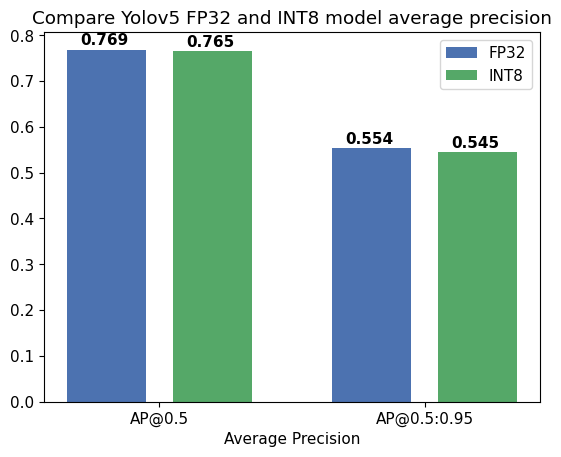

In [17]:
%matplotlib inline
plt.style.use("seaborn-deep")
fp32_acc = np.array([fp32_ap5, fp32_ap_full])
int8_acc = np.array([int8_ap5, int8_ap_full])
x_data = ("AP@0.5", "AP@0.5:0.95")
x_axis = np.arange(len(x_data))
fig = plt.figure()
fig.patch.set_facecolor("#FFFFFF")
fig.patch.set_alpha(0.7)
ax = fig.add_subplot(111)
plt.bar(x_axis - 0.2, fp32_acc, 0.3, label="FP32")
for i in range(0, len(x_axis)):
    plt.text(
        i - 0.3,
        round(fp32_acc[i], 3) + 0.01,
        str(round(fp32_acc[i], 3)),
        fontweight="bold",
    )
plt.bar(x_axis + 0.2, int8_acc, 0.3, label="INT8")
for i in range(0, len(x_axis)):
    plt.text(
        i + 0.1,
        round(int8_acc[i], 3) + 0.01,
        str(round(int8_acc[i], 3)),
        fontweight="bold",
    )
plt.xticks(x_axis, x_data)
plt.xlabel("Average Precision")
plt.title("Compare Yolov5 FP32 and INT8 model average precision")

plt.legend()
plt.show()

## Inference Demo Performance Comparison

This part shows how to use the Ultralytics model detection code ["detect.py"](https://github.com/ultralytics/yolov5/blob/master/detect.py) to run synchronous inference, using the OpenVINO Python API on two images.

In [18]:
command_detect = "cd yolov5 && python detect.py --weights ./yolov5m/INT8_openvino_model"
display(Markdown(f"`{command_detect}`"))
%sx $command_detect

`cd yolov5 && python detect.py --weights ./yolov5m/INT8_openvino_model`

["\x1b\x1bdetect: \x1bweights=['./yolov5m/INT8_openvino_model'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1",
 'YOLOv5 🚀 v7.0-0-g915bbf2 Python-3.8.10 torch-1.13.1+cpu CPU',
 '',
 'Loading yolov5m/INT8_openvino_model for OpenVINO inference...',
 'image 1/2 /home/ea/work/openvino_notebooks/notebooks/111-yolov5-quantization-migration/yolov5/data/images/bus.jpg: 640x640 4 persons, 1 bus, 30.6ms',
 'image 2/2 /home/ea/work/openvino_notebooks/notebooks/111-yolov5-quantization-migration/yolov5/data/images/zidane.jpg: 640x640 3 persons, 2 ties, 23.2ms',
 'Speed: 11.6ms pre-process, 26.9ms inference, 1.9ms NMS per image at shape

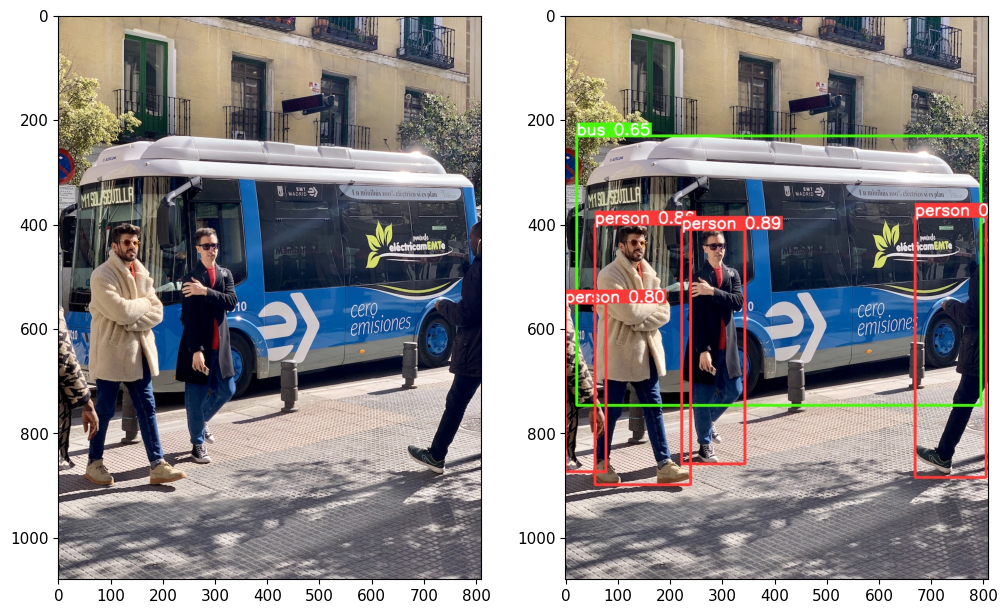

In [19]:
%matplotlib inline
import matplotlib.image as mpimg

fig2 = plt.figure(figsize=(12, 9))
fig2.patch.set_facecolor("#FFFFFF")
fig2.patch.set_alpha(0.7)
axarr1 = fig2.add_subplot(121)
axarr2 = fig2.add_subplot(122)
ori = mpimg.imread("./yolov5/data/images/bus.jpg")
result = mpimg.imread("./yolov5/runs/detect/exp/bus.jpg")
_ = axarr1.imshow(ori)
_ = axarr2.imshow(result)

## Benchmark

In [20]:
print("Inference FP32 model (OpenVINO IR) on CPU")
!benchmark_app -m  {fp32_path} -d CPU -api async -t 15

if "GPU" in core.available_devices:
    print("Inference FP32 model (OpenVINO IR) on GPU")
    !benchmark_app -m  {fp32_path} -d GPU -api async -t 15

Inference FP32 model (OpenVINO IR) on CPU
[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 52.42 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch 

In [21]:
gpu_available = "GPU" in core.available_devices

print("Inference FP16 model (OpenVINO IR) on CPU")
!benchmark_app -m {fp16_path} -d CPU -api async -t 15

if gpu_available:
    print("Inference FP16 model (OpenVINO IR) on GPU")
    !benchmark_app -m {fp16_path} -d GPU -api async -t 15

Inference FP16 model (OpenVINO IR) on CPU
[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 39.60 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch 

In [22]:
print("Inference INT8 model (OpenVINO IR) on CPU")
!benchmark_app -m {int8_path} -d CPU -api async -t 15

if gpu_available:
    print("Inference INT8 model (OpenVINO IR) on GPU")
    !benchmark_app -m {int8_path} -d GPU -api async -t 15

Inference INT8 model (OpenVINO IR) on CPU
[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 43.08 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch 

## References

* [Ultralytics YOLOv5](https://github.com/ultralytics/yolov5)
* [OpenVINO Post-training Optimization Tool](https://docs.openvino.ai/latest/pot_introduction.html)
* [NNCF Post-training quantization](https://docs.openvino.ai/latest/nncf_ptq_introduction.html)
* [Model Optimizer](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html#doxid-openvino-docs-m-o-d-g-deep-learning-model-optimizer-dev-guide)
